In [1]:
import pymc as pm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import matplotlib.cm as cm
import pandas as pd
import pytensor.tensor as pt
import json

#Make sure it can see the system path

import sys
from pathlib import Path

PROJECT_ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))



In [2]:
from utils import load_data,plot_helpers
#reload(load_data)
from modeling import bayes

In [3]:
for_paper=False
for_talk=False

if for_paper:

    import scienceplots #http://doi.org/10.5281/zenodo.4106649
    plt.style.use(('science','nature'))
elif for_talk:
    plt.style.use("dark-background")
else:
    az.style.use("arviz-doc")
    
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
from utils.plot_helpers import *

In [5]:
carbon_cycle_evidence=load_data.load_carbon_cycle()


In [6]:
feedback_evidence=load_data.feedback_dictionary(generation="CMIP6")

In [7]:
temperature_evidence={}
temperature_evidence["T2000"]=load_data.load_temperature(2000)

In [8]:
evidence = carbon_cycle_evidence | feedback_evidence | temperature_evidence

# Observations
Use GISTEMP and HadCRUT global mean temperature observations.  Assume the reported ensembles are samples from some posterior.

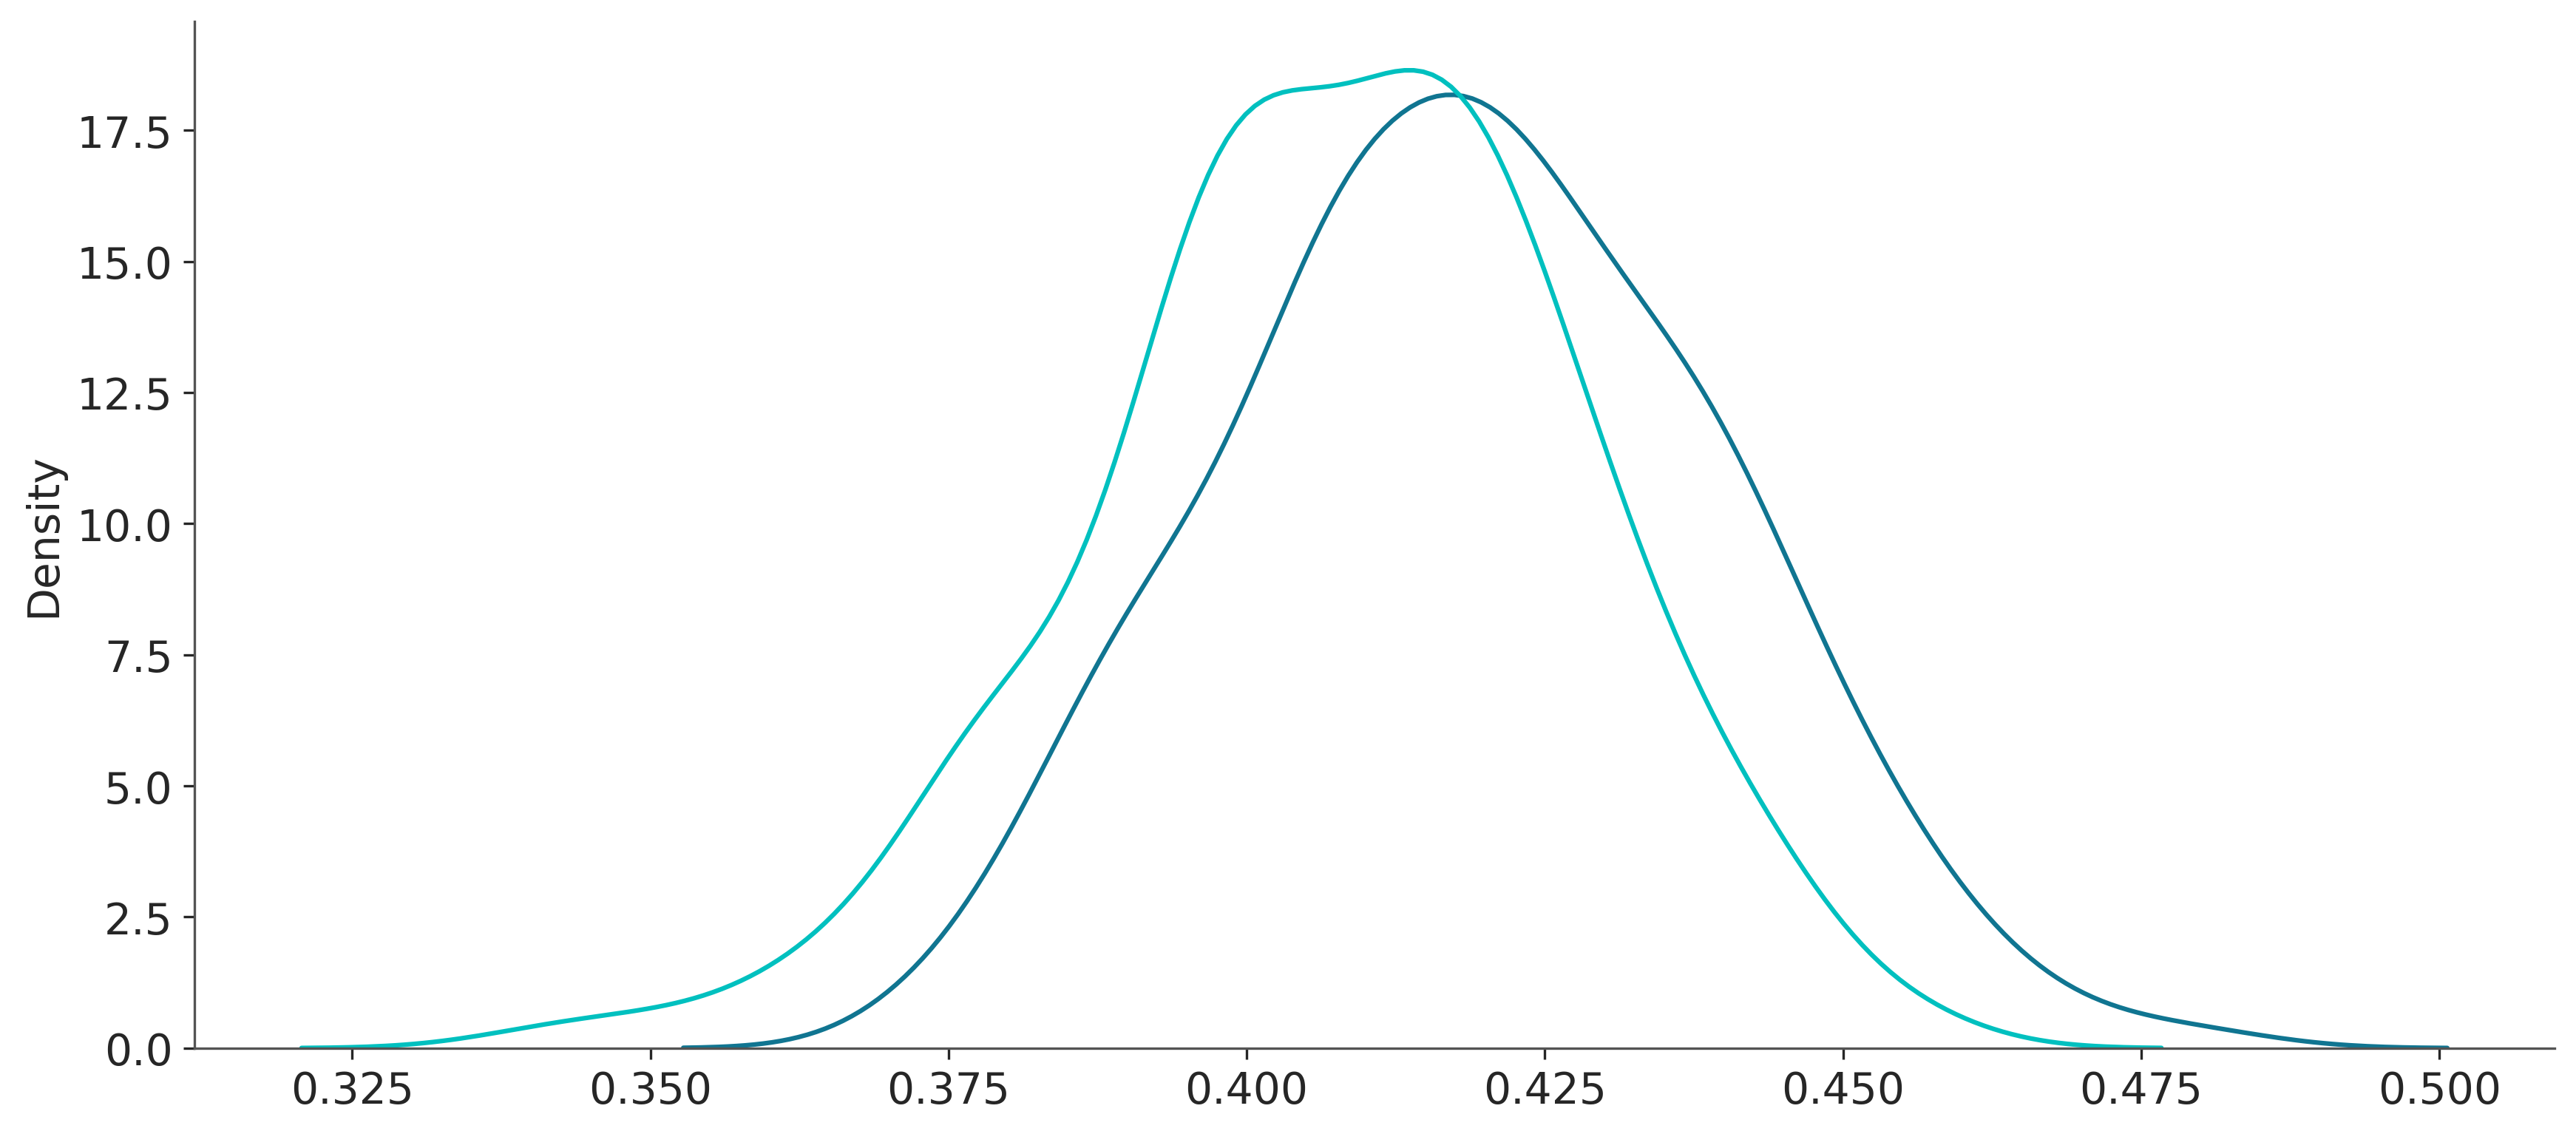

In [9]:
#Observations
hadcrut_file=\
"data/global_mean_T/HadCRUT.5.0.2.0.analysis.ensemble_series.global.annual.nc"
hadcrut=xr.open_dataset(hadcrut_file).tas
hadcrut= hadcrut-\
hadcrut.sel(time=slice("1951-1-1","1980-12-31")).mean(dim="time")

gistemp_file="data/global_mean_T/ensembleCombinedSeries_Global.nc"
gistemp=xr.open_dataset(gistemp_file).tas.groupby("time.year").mean(dim="time")


gistemp_2000=gistemp.sel(year=2000).values

hadcrut_2000=hadcrut.sel(time=slice("2000-1-1","2000-12-31")).mean(dim="time")-\
hadcrut.sel(time=slice("1951-1-1","1980-12-31")).mean(dim="time").values
tmp=sns.kdeplot(gistemp_2000,label="GISTEMP")
tmp=sns.kdeplot(hadcrut_2000,label="HadCRUT")


In [10]:
def add_temperature_observations(model,var_name,observations=None,sigma_obs_iv=0.1,obs_name="GISTEMP"):
    with model:
        if "actual" not in model.named_vars:
            T_realized = pm.Normal("actual",model[var_name],sigma_obs_iv)
        if observations is not None:
            # assume observations is an ensemble of posterior draws
            T_obs = pm.Normal(obs_name,mu=model["actual"],sigma=observations.std(),observed=observations)

# What is the externally forced contribution to the temperature anomaly in 2000?

In the CMIP models:
$$T_i^j \sim N(T_i,\sigma_i)$$
(Each ensemble member j is the forced response T_i in the ESM i plus internal variability in ESM_i)

The forced responses vary structurally across the models
$$T_i \sim N(T_f,\sigma_{struct})$$

The observations are 
$$T_{2000} = T_f + \epsilon $$
where $T_f$ is the forced response and $\epsilon$ the internal variability

### Fixed effects, wide priors

In [11]:

with bayes.build_fixed_effects_model(evidence["T2000"],var_name="T2000",
                               priors={"T2000":lambda name:pm.Normal(0,100)}) as fixmodel:
    actual = pm.Normal("actual",fixmodel["T2000"],sigma=0.1) # add the actual T_realized for later
    trace_fix=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma, actual]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now add the observations to compare the updates (fixobs) with the CMIP-only posterior (trace_fix).  

In [12]:
with fixmodel:
    add_temperature_observations(fixmodel,"T2000",observations=hadcrut_2000.values,\
                                 sigma_obs_iv=0.1,obs_name="HadCRUT")
    add_temperature_observations(fixmodel,"T2000",observations=gistemp_2000,\
                                 sigma_obs_iv=0.1,obs_name="Gistemp")
    fixobs=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma, actual]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### Fixed effects, narrow (wrong) priors

In [13]:

with bayes.build_fixed_effects_model(evidence["T2000"],var_name="T2000",\
                               priors={"T2000":lambda name:pm.Normal(0,0.01)}) as fixmodel_tight:
    actual = pm.Normal("actual",fixmodel_tight["T2000"],sigma=0.1) # add the actual T_realized for later
    trace_fix_tight=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma, actual]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now add the observations to compare the updates (fixobs_tight) with the CMIP-only posterior (trace_fix_tight).  

In [14]:
with fixmodel_tight:
    add_temperature_observations(fixmodel_tight,"T2000",observations=hadcrut_2000.values,\
                                 sigma_obs_iv=0.1,obs_name="HadCRUT")
    add_temperature_observations(fixmodel_tight,"T2000",observations=gistemp_2000,\
                                 sigma_obs_iv=0.1,obs_name="Gistemp")
    fixobs_tight=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma, actual]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


###  Random effects, narrow priors

In [15]:
# calculate trace for rho = 0
var_name="T2000"
priors0={}
priors0["rho"] = lambda name:0.0
priors0["T2000"] = lambda name: pm.Normal(name,0,100)

with bayes.build_correlated_random_effects_model(data = \
                                           evidence[var_name],priors=priors0,var_name=var_name) as model_0:
    actual = pm.Normal("actual",model_0["T2000"],sigma=0.1) # add the actual T_realized for later
    # Using an uncorrelated random effects model, sample the trace for forced and realized T2000
    trace_0=pm.sample(target_accept=.99)
  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma_struct, sigma_iv, z_m, actual]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


Add the observations

In [16]:
with model_0:
    add_temperature_observations(model_0,"T2000",observations=hadcrut_2000.values,\
                                 sigma_obs_iv=0.1,obs_name="HadCRUT")
    add_temperature_observations(model_0,"T2000",observations=gistemp_2000,\
                                 sigma_obs_iv=0.1,obs_name="Gistemp")
    obs_0=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma_struct, sigma_iv, z_m, actual]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


In [17]:
# calculate trace for rho = 0, tight (wrong) priors
var_name="T2000"
priors0t={}
priors0t["rho"] = lambda name:0.0
priors0t["T2000"] = lambda name: pm.Normal(name,0,.01)

with bayes.build_correlated_random_effects_model(data = \
                                           evidence[var_name],priors=priors0t,var_name=var_name) as model_0_tight:
    actual = pm.Normal("actual",model_0_tight["T2000"],sigma=0.1) # add the actual T_realized for later
    # Using an uncorrelated random effects model, sample the trace for forced and realized T2000
    trace_0_tight=pm.sample(target_accept=.99)
  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma_struct, sigma_iv, z_m, actual]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [18]:
with model_0_tight:
    add_temperature_observations(model_0_tight,"T2000",observations=hadcrut_2000.values,\
                                 sigma_obs_iv=0.1,obs_name="HadCRUT")
    add_temperature_observations(model_0_tight,"T2000",observations=gistemp_2000,\
                                 sigma_obs_iv=0.1,obs_name="Gistemp")
    obs_0_tight=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma_struct, sigma_iv, z_m, actual]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_39776/1125176714.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


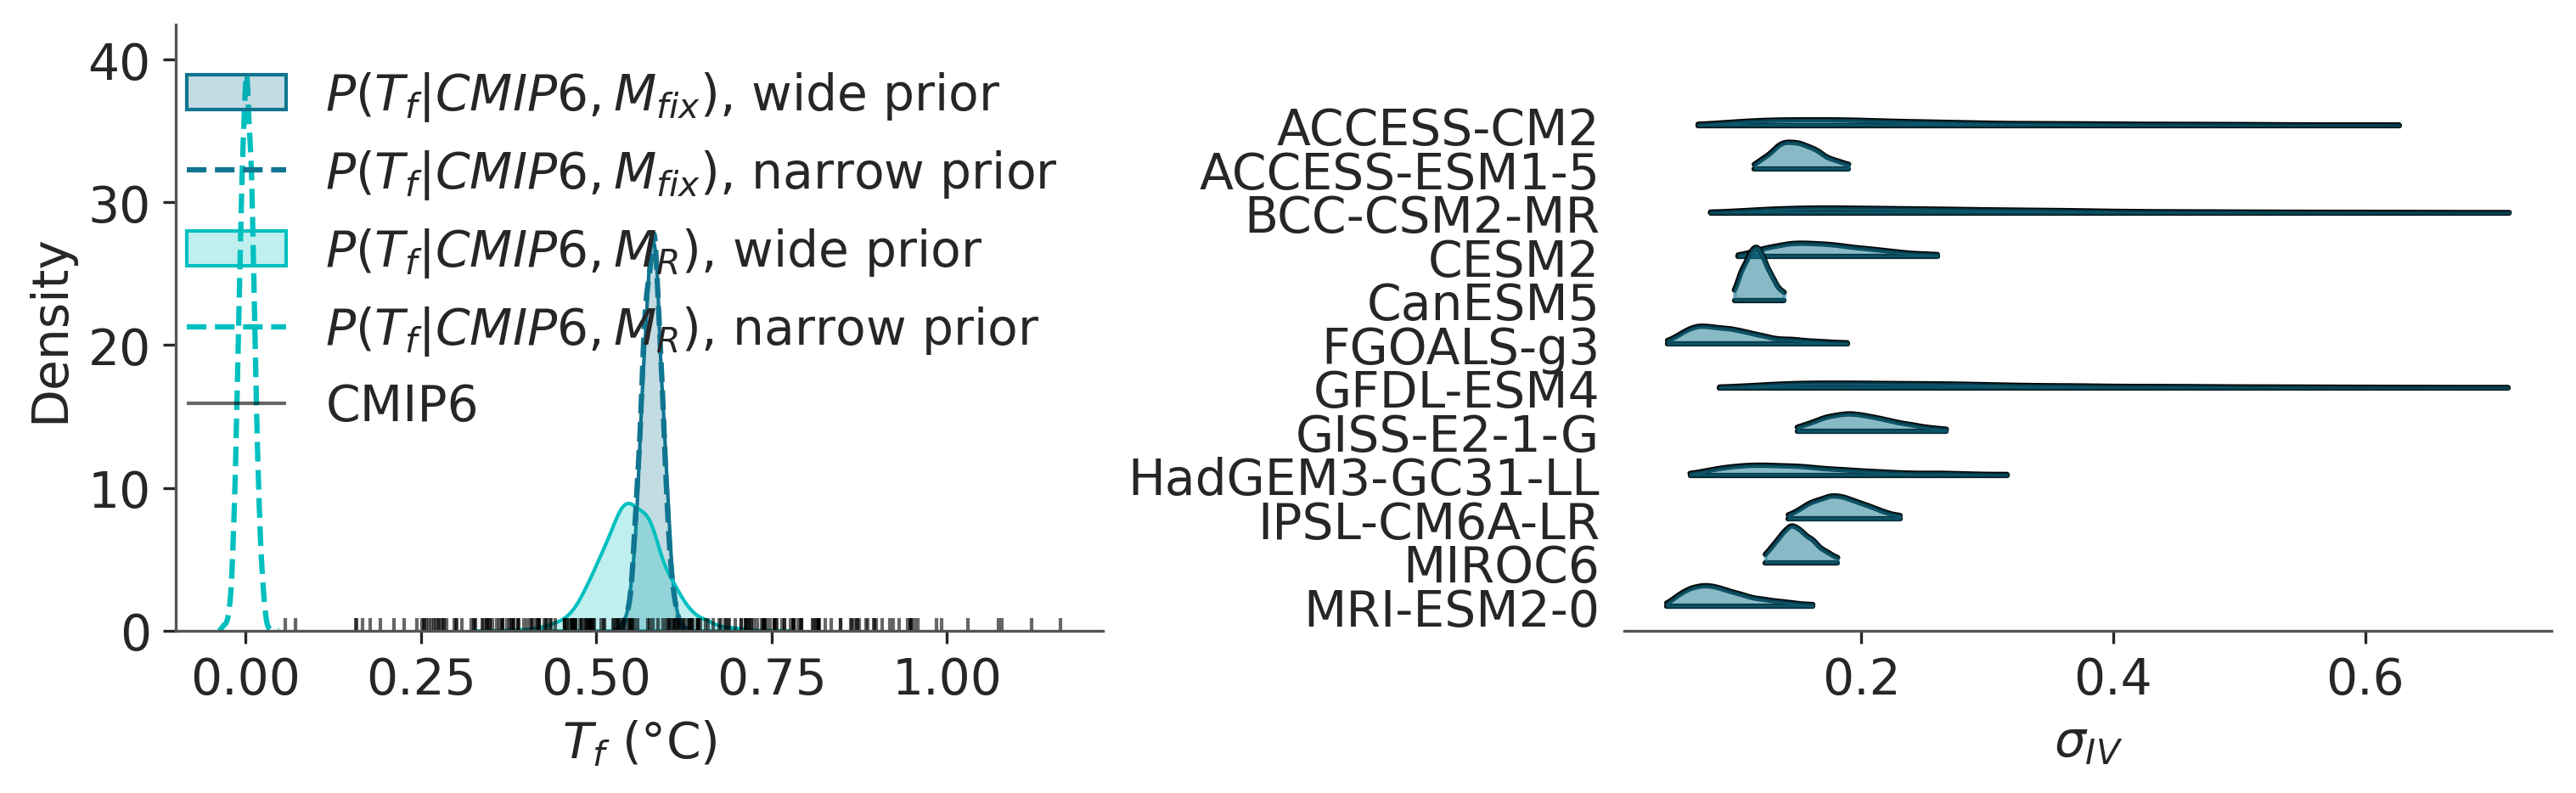

In [19]:
# Posteriors
plt.figure(figsize=(10,3))
#plot_posterior(trace_fix,"actual",label="fix Actual")
ax=plt.subplot(121)
plot_helpers.plot_posterior(trace_fix,"T2000",label=r"$P(T_f|CMIP6, M_{fix})$, wide prior",ax=ax,\
                           fill=True)
plot_helpers.plot_posterior(trace_fix_tight,"T2000",\
                            label=r"$P(T_f|CMIP6, M_{fix})$, narrow prior",color=colors[0],ls="--",ax=ax)
plot_helpers.plot_posterior(trace_0,"T2000",color=colors[1],label=r"$P(T_f|CMIP6, M_{R})$, wide prior",ax=ax,\
                           fill=True)
plot_helpers.plot_posterior(trace_0_tight,"T2000",\
                            color=colors[1],label=r"$P(T_f|CMIP6, M_{R})$, narrow prior",ax=ax,ls="--")
# plt.legend()
sns.rugplot(evidence["T2000"],c="k",label="CMIP6",alpha=.6,height=0.02)

# plot_posterior(trace_fix,"T2000",label=r"$P(T_f|CMIP6, M_{fix})$",ax=ax)
# #plot_posterior(trace_0,"actual",label="RE Actual")
# plot_posterior(trace_0,"T2000",label=r"$P(T_f|CMIP6, M_{R})$",ax=ax)
plt.legend()
plt.xlabel(r"$T_f$ (°C)")

ax2=plt.subplot(122)
az.plot_forest(trace_0,var_names=["sigma_iv"],kind="ridgeplot",combined=True,\
               ridgeplot_alpha=.5,ridgeplot_overlap=1,ax=ax2)
ax2.set_yticklabels(np.unique(evidence["T2000"].model)[::-1])
ax2.set_xlabel("$\sigma_{IV}$")
plt.tight_layout()
if for_paper:
    plt.savefig("FIGS/T2000.pdf")

In [20]:
# The rE and fixed effects models calculate the forced response.   Put back in internal variability to get the expected realized.

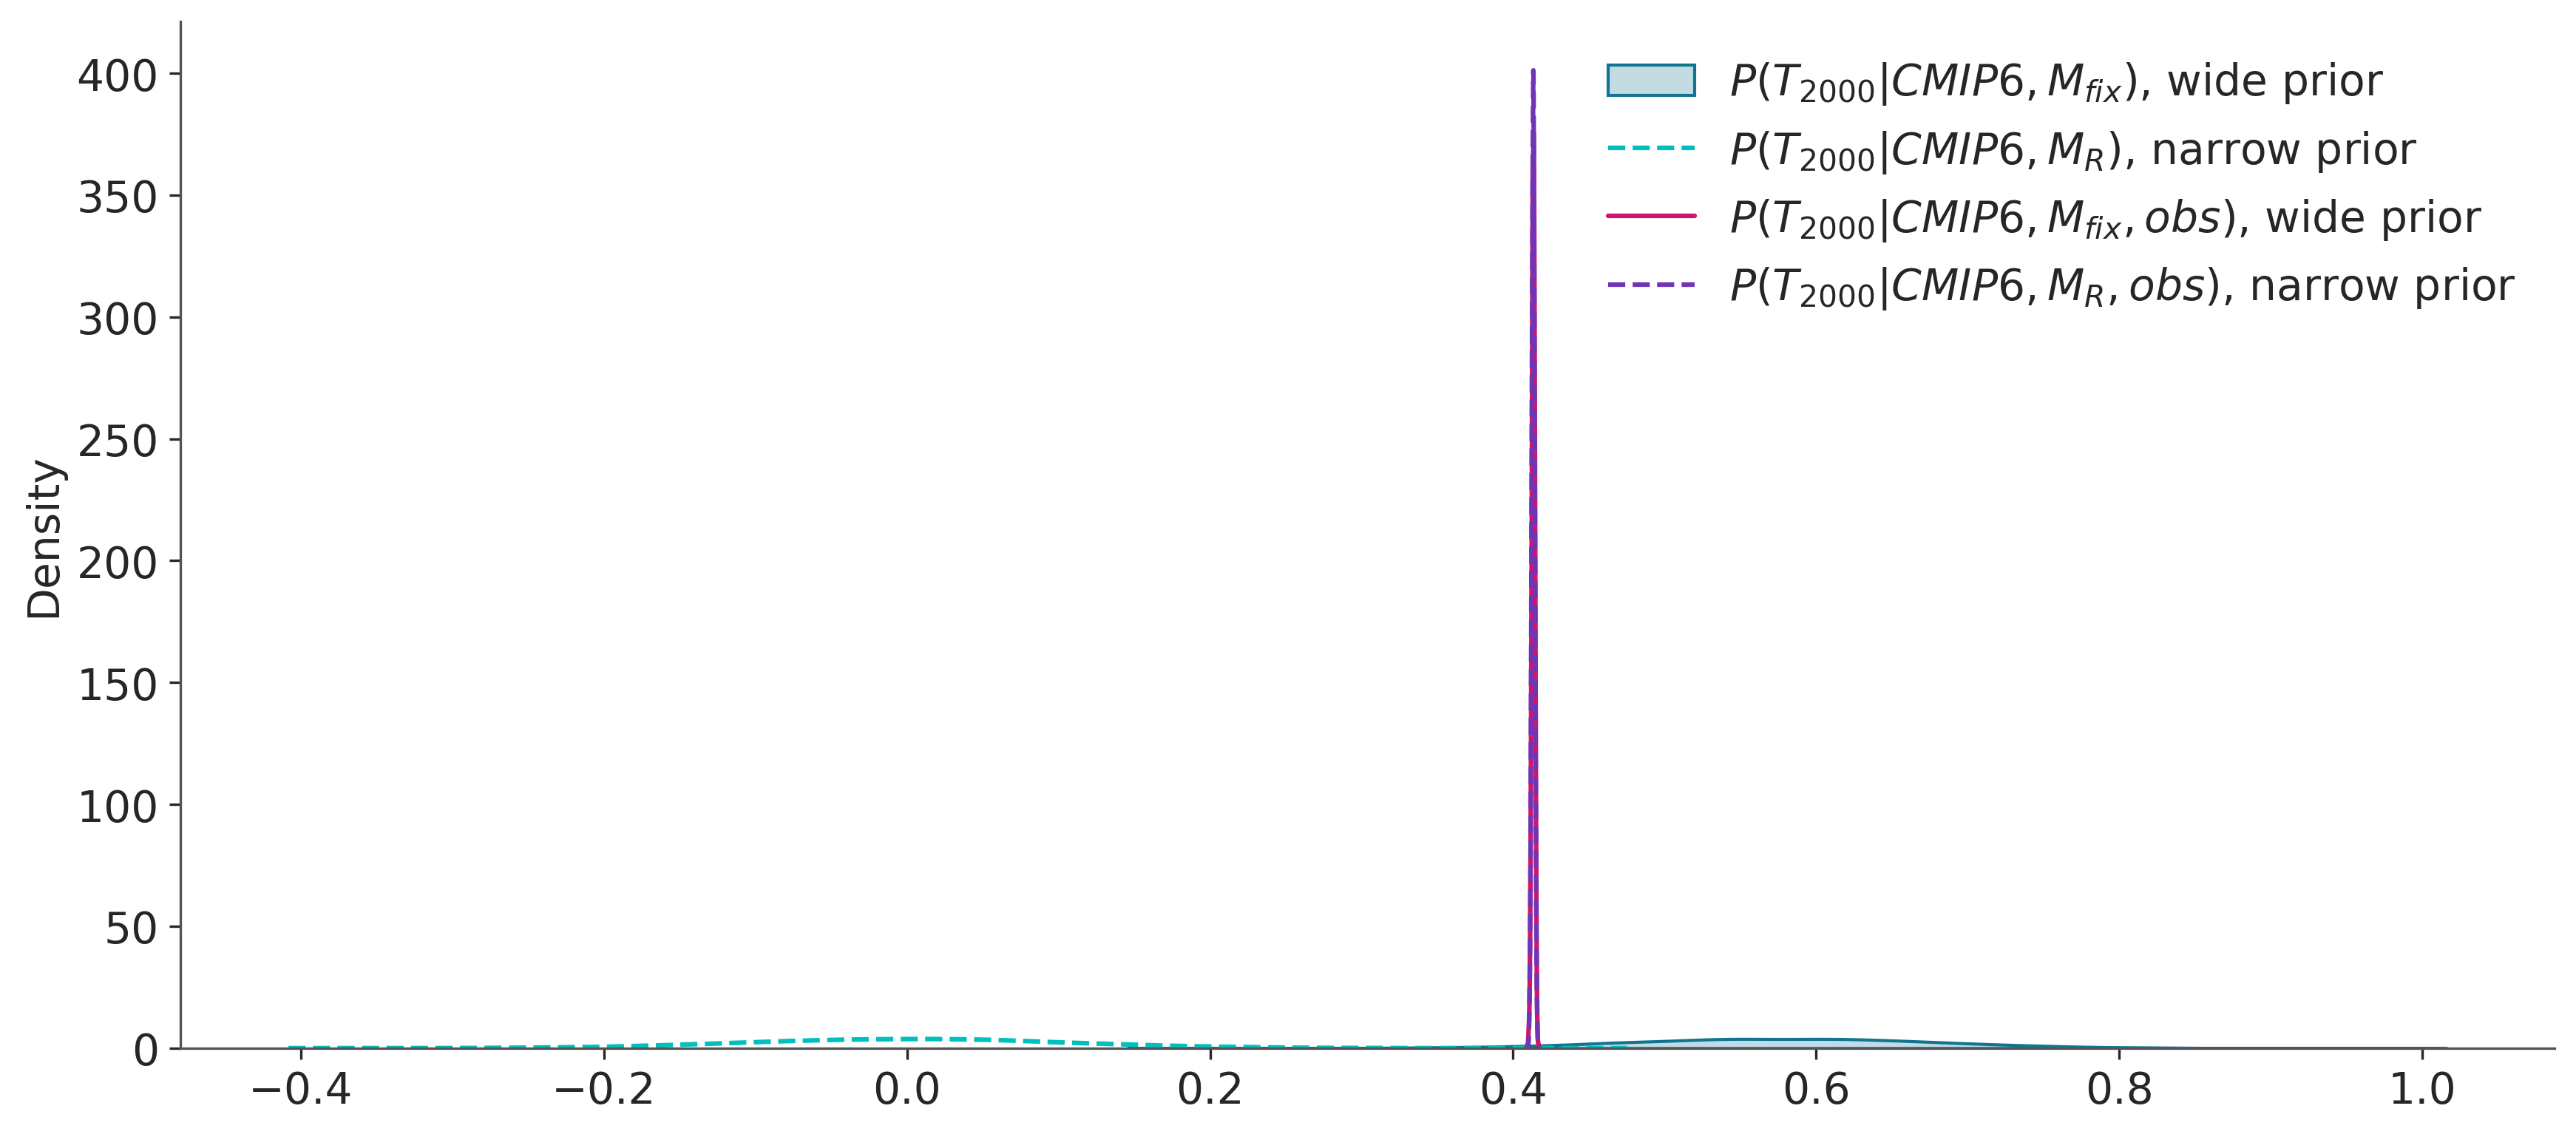

In [23]:
ax=plt.subplot(111)
plot_helpers.plot_posterior(trace_fix,"actual",label=r"$P(T_{2000}|CMIP6, M_{fix})$, wide prior",ax=ax,\
                           fill=True)
# plot_helpers.plot_posterior(trace_fix_tight,"actual",\
#                             label=r"$P(T_{2000}|CMIP6, M_{fix})$, narrow prior",color=colors[0],ls="--",ax=ax)
# plot_helpers.plot_posterior(trace_0,"actual",color=colors[1],label=r"$P(T_f|CMIP6, M_{R})$, wide prior",ax=ax,\
#                            fill=True)
plot_helpers.plot_posterior(trace_0_tight,"actual",\
                            color=colors[1],label=r"$P(T_{2000}|CMIP6, M_{R})$, narrow prior",ax=ax,ls="--")


plot_helpers.plot_posterior(fixobs,"actual",label=r"$P(T_{2000}|CMIP6, M_{fix},obs)$, wide prior",ax=ax,\
                           fill=False,c=colors[-1])
# plot_helpers.plot_posterior(fixobs_tight,"actual",\
#                             label=r"$P(T_{2000}|CMIP6, M_{fix},obs)$, narrow prior",color=colors[-1],ls="--",ax=ax)
# plot_helpers.plot_posterior(obs_0,"actual",color=colors[-2],label=r"$P(T_f|CMIP6, M_{R},obs)$, wide prior",ax=ax,\
#                            fill=True)
plot_helpers.plot_posterior(obs_0_tight,"actual",\
                            color=colors[-2],label=r"$P(T_{2000}|CMIP6, M_{R},obs)$, narrow prior",ax=ax,ls="--")
#plt.legend(fontsize=4)
plt.legend()
if for_paper:
    plt.savefig("FIGS/T_obs.pdf")